# ernie 2.0

We assume ernie and xlm-r use same pre-train data

## Pre software install

In [1]:
!pip install paddle-ernie

  Created wheel for paddle-ernie: filename=paddle_ernie-0.0.4.dev1-cp37-none-any.whl size=21722 sha256=93107be76671eb1c86c458a23449d17aa5f683328aa26bdf857f8cd19b0ec959
  Stored in directory: /Users/charles/Library/Caches/pip/wheels/c4/82/c9/cc31422e3d04d812d968286445a5481d411e855c6c6d24f3a2
Successfully built paddle-ernie


In [4]:
!python -m pip install paddlepaddle==1.8.5 -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://mirror.baidu.com/pypi/simple
     |████████████████████████████████| 46.4MB 1.7MB/s 
     |████████████████████████████████| 51kB 1.5MB/s 
  Created wheel for pathlib: filename=pathlib-1.0.1-cp37-none-any.whl size=14348 sha256=b605f00e3ff54e90c87c61b2f23612fdfb5e5f5ad14d15f0a9986654065dcef0
  Stored in directory: /Users/charles/Library/Caches/pip/wheels/37/41/f2/be991aaac17dd855bce2cf77b92722e05b27f782aec549d64c
Successfully built pathlib
ERROR: tensorflow 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.14.0 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2


In [5]:
import numpy as np
import paddle.fluid.dygraph as D
from ernie.tokenizing_ernie import ErnieTokenizer
from ernie.modeling_ernie import ErnieModel

D.guard().__enter__() # activate paddle `dygrpah` mode

model = ErnieModel.from_pretrained('ernie-1.0')    # Try to get pretrained model from server, make sure you have network connection
model.eval()
tokenizer = ErnieTokenizer.from_pretrained('ernie-1.0')

ids, _ = tokenizer.encode('hello world')
ids = D.to_variable(np.expand_dims(ids, 0))  # insert extra `batch` dimension
pooled, encoded = model(ids)                 # eager execution
print(pooled.numpy())                        # convert  results to numpy

downloading https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz: 788478KB [01:27, 9057.32KB/s]                             
[[-1.         -1.          0.99479663 -0.99986964 -0.7872066  -1.
  -0.99919444  0.985997   -0.22648102  0.97202295 -0.9994965  -0.982234
  -0.6821966  -0.9998574  -0.83046496 -0.9804977  -1.          0.9999509
  -0.55144966  0.48973152 -1.          1.          0.14248642 -0.71969527
  -0.9055147   0.97965705 -0.999682    0.85135585  1.         -0.39387462
  -0.99999905  0.9999919  -0.9992018  -0.09899261  0.99996     0.7490412
  -0.9999922  -0.9657562  -0.9960676  -0.95335084  0.9999292  -0.9197153
  -0.99989647  0.63038546 -0.9860959  -0.99991727 -1.          0.99999994
  -0.99999994 -0.82624584 -0.9744699   0.99909854  1.         -0.9999999
  -0.9999997  -0.999507   -0.02157898 -1.          0.99975914  0.9932416
  -0.99919933 -1.          1.          0.39329714 -0.31263566 -0.9984498
  -0.9835464  -0.9999865  -0.98631394  0.99999607  0.98583347 -0.99960

In [6]:
!git clone https://github.com/PaddlePaddle/ERNIE

Cloning into 'ERNIE'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
Receiving objects: 100% (1880/1880), 88.77 MiB | 33.00 KiB/s, done.
remote: Total 1880 (delta 1), reused 0 (delta 0), pack-reused 1873
Resolving deltas: 100% (1023/1023), done.


## Preprocessing

### add preprocessing lib

In [1]:
import sys
import argparse
import struct
import random as r
import re
import gzip
import logging
from itertools import accumulate
from functools import reduce, partial, wraps
from propeller import log
from propeller.paddle.data import feature_pb2, example_pb2

### Making Pre Training Data


In [ ]:
path = 'hindi-english/train_14k_split_conll.tsv'

In [ ]:
def gen_segs(segment_piece):
    if len(segment_piece) == 0:
        return []
    else:
        return [min(segment_piece)] * len(segment_piece)

whit_space_pat = re.compile(r'\S+')
def segment(inputs, inputs_segment):
    ret = [r.span() for r in whit_space_pat.finditer(inputs)]
    ret = [(inputs[s: e], gen_segs(inputs_segment[s: e])) for i, (s, e) in enumerate(ret)]
    return ret

In [ ]:
def tokenize(sen, seg_info):
    sen = sen.lower()
    res_word, res_segments = [], []
    for match in pat.finditer(sen):
        words, pos = _wordpiece(match.group(0), vocab=vocab_set, unk_token='[UNK]')
        start_of_word = match.span()[0]
        for w, p in zip(words, pos):
            res_word.append(w)
            res_segments.append(gen_segs(seg_info[p[0] + start_of_word: p[1] + start_of_word]))
    return res_word, res_segments

In [ ]:
def parse_txt(line):
    if len(line) == 0:
        return []
    line = line.decode('utf8')
    ret_line, ret_seginfo = [], []

    for l, i in segment(line, list(range(len(line)))):
        for ll, ii in zip(*tokenize(l, i)):
            ret_line.append(ll)
            ret_seginfo.append(ii)

    if args.check and r.random() < 0.005:
        print('****', file=sys.stderr)
        print(line, file=sys.stderr)
        print('|'.join(ret_line), file=sys.stderr)
        print(ret_seginfo, file=sys.stderr)
        print('****', file=sys.stderr)

    ret_line = [vocab.get(r, vocab['[UNK]']) for r in ret_line]
    ret_seginfo = [[-1] if i == [] else i for i in ret_seginfo] #for sentence piece only
    ret_seginfo = [min(i) for i in ret_seginfo]
    return ret_line, ret_seginfo

In [ ]:
def build_example(slots):
    txt, seginfo = slots
    txt_fe_list = feature_pb2.FeatureList(feature=[feature_pb2.Feature(int64_list=feature_pb2.Int64List(value=t)) for t in txt])
    segsinfo_fe_list = feature_pb2.FeatureList(feature=[feature_pb2.Feature(int64_list=feature_pb2.Int64List(value=s)) for s in seginfo])
    assert len(txt_fe_list.feature) == len(segsinfo_fe_list.feature), 'txt[%d] and seginfo[%d] size not match' % (len(txt_fe_list.feature), len(segsinfo_fe_list.feature))
    features = {
        'txt':  txt_fe_list,
        'segs': segsinfo_fe_list,
    }

    ex = example_pb2.SequenceExample(feature_lists=feature_pb2.FeatureLists(feature_list=features))
    return ex

In [ ]:
def write_gz(serialized, to_file):
    l = len(serialized)
    packed_data = struct.pack('i%ds' % l, l, serialized)
    to_file.write(packed_data)


In [3]:
def build_bb(from_file, to_file):
    slots = []
    for i, line in enumerate(from_file):
        line = line.strip()
        if args.verbose and i % 10000 == 0:
            log.debug(i)
        if len(line) == 0:
            if len(slots) != 0:
                transposed_slots = list(zip(*slots))
                ex = build_example(transposed_slots)
                write_gz(ex.SerializeToString(), to_file)
                slots = []
            continue
        parsed_line = parse_txt(line)
        slots.append(parsed_line)

    if len(slots) != 0:
        transposed_slots = list(zip(*slots))
        ex = build_example(transposed_slots)
        write_gz(ex.SerializeToString(), to_file)
        slots = []
losses = [1.1573,1.1191,0.8751,0.7321,0.5612,0.5112,0.5002,0.4997,0.4993,0.4990]

In [ ]:
from ernie.tokenizing_ernie import _wordpiece
    pat = re.compile(r'([a-zA-Z0-9]+|\S)')

    vocab = {j.strip().split(b'\t')[0].decode('utf8'): i for i, j in enumerate(open(args.vocab, 'rb'))}
    vocab_set = set(vocab.keys())


    with open(path, 'rb') as from_file, gzip.open(args.tgt, 'wb') as to_file:
        #log.info('making gz from bb %s ==> %s' % (from_file, to_file))
        build_bb(from_file, to_file)
        #log.info('done: %s' % to_file)

### Pretrain the data

In [ ]:
if not os.path.exists(path):
        raise ValueError('--from_pretrained not found: %s' % args.from_pretrained)
    cfg_file_path = os.path.join(args.from_pretrained, 'ernie_config.json')
    param_path = os.path.join(args.from_pretrained, 'params')
    vocab_path = os.path.join(args.from_pretrained, 'vocab.txt')
    assert os.path.exists(cfg_file_path) and os.path.exists(param_path) and os.path.exists(vocab_path)


    hparams_cli = propeller.parse_hparam(args)
    hparams_config_file = json.loads(open(cfg_file_path).read())
    default_hparams = propeller.HParams(
        batch_size=50,
        warmup_steps=10000,
        learning_rate=1e-4,
        weight_decay=0.01,
        use_fp16=False,
    )

    hparams = default_hparams.join(propeller.HParams(**hparams_config_file)).join(hparams_cli)

    default_run_config=dict(
        max_steps=1000000,
        save_steps=10000,
        log_steps=10,
        max_ckpt=3,
        skip_steps=0,
        eval_steps=-1)

    run_config = dict(default_run_config, **json.loads(args.run_config))
    run_config = propeller.RunConfig(**run_config)

    tokenizer = ErnieTokenizer.from_pretrained(args.from_pretrained)


    train_ds = make_pretrain_dataset('train', args.data_dir,
            vocab=tokenizer.vocab, hparams=hparams, args=args)

    seq_shape = [-1, args.max_seqlen]
    ints_shape = [-1,]
    shapes = (seq_shape, seq_shape, ints_shape, [-1, 2], ints_shape) 
    types = ('int64', 'int64', 'int64', 'int64', 'int64')

    train_ds.data_shapes = shapes
    train_ds.data_types = types
    ws = None

    varname_to_warmstart = re.compile(r'.*')
    if args.from_pretrained is not None:
        warm_start_dir = os.path.join(args.from_pretrained, 'params')
        ws = propeller.WarmStartSetting(
                predicate_fn=lambda v: varname_to_warmstart.match(v.name) and os.path.exists(os.path.join(warm_start_dir, v.name)),
                from_dir=warm_start_dir
            )

    ernie_learner = propeller.Learner(ernie_pretrain_model_fn, run_config, params=hparams, warm_start_setting=ws)
    ernie_learner.train(train_ds)

## Using ernie 2.0

In [ ]:
def model_fn(features, mode, params, run_config):
    ernie = ErnieModelForSequenceClassification(params, name='')
    if not params is propeller.RunMode.TRAIN:
        ernie.eval()

    metrics, loss = None, None
    if mode is propeller.RunMode.PREDICT:
        src_ids, sent_ids = features
        _, logits = ernie(src_ids, sent_ids)
        predictions = [logits,]
    else:
        src_ids, sent_ids, labels = features
        if mode is propeller.RunMode.EVAL:
            loss, logits = ernie(src_ids, sent_ids, labels=labels)
            pred = L.argmax(logits, axis=1)
            acc = propeller.metrics.Acc(labels, pred)
            metrics = {'acc': acc}
            predictions = [pred]
        else:
            loss, logits = ernie(src_ids, sent_ids, labels=labels)
            scheduled_lr, _ = optimization(
                loss=loss,
                warmup_steps=int(run_config.max_steps * params['warmup_proportion']),
                num_train_steps=run_config.max_steps,
                learning_rate=params['learning_rate'],
                train_program=F.default_main_program(), 
                startup_prog=F.default_startup_program(),
                use_fp16=params.use_fp16,
                weight_decay=params['weight_decay'],
                scheduler="linear_warmup_decay",
                )
            propeller.summary.scalar('lr', scheduled_lr)
            predictions = [logits,]

    return propeller.ModelSpec(loss=loss, mode=mode, metrics=metrics, predictions=predictions)

In [ ]:
if not os.path.exists(args.from_pretrained):
        raise ValueError('--from_pretrained not found: %s' % args.from_pretrained)
    cfg_file_path = os.path.join(args.from_pretrained, 'ernie_config.json')
    param_path = os.path.join(args.from_pretrained, 'params')
    vocab_path = os.path.join(args.from_pretrained, 'vocab.txt')

    assert os.path.exists(cfg_file_path) and os.path.exists(param_path) and os.path.exists(vocab_path)

    hparams_cli = propeller.parse_hparam(args)
    hparams_config_file = json.loads(open(cfg_file_path).read())
    default_hparams = propeller.HParams(
        batch_size=32,
        num_labels=3,
        warmup_proportion=0.1,
        learning_rate=5e-5,
        weight_decay=0.01,
        use_task_id=False,
        use_fp16=args.use_fp16,
    )

    hparams = default_hparams.join(propeller.HParams(**hparams_config_file)).join(hparams_cli)

    default_run_config=dict(
        max_steps=args.epoch * 390000 / hparams.batch_size,
        save_steps=1000,
        log_steps=10,
        max_ckpt=1,
        skip_steps=0,
        model_dir=tempfile.mkdtemp(),
        eval_steps=100)
    run_config = dict(default_run_config, **json.loads(args.run_config))
    run_config = propeller.RunConfig(**run_config)

    tokenizer = ErnieTokenizer.from_pretrained(args.from_pretrained)
    #tokenizer = ErnieTinyTokenizer.from_pretrained(args.from_pretrained)
    unk_id = tokenizer.vocab['[UNK]']

    shapes = ([-1, args.max_seqlen], [-1, args.max_seqlen], [-1])
    types = ('int64', 'int64', 'int64')
    if not args.do_predict:
        feature_column = propeller.data.FeatureColumns([
            propeller.data.TextColumn('title', unk_id=unk_id, vocab_dict=tokenizer.vocab, tokenizer=tokenizer.tokenize),
            propeller.data.TextColumn('comment', unk_id=unk_id, vocab_dict=tokenizer.vocab, tokenizer=tokenizer.tokenize),
            propeller.data.LabelColumn('label', vocab_dict={
                b"contradictory": 0,
                b"contradiction": 0,
                b"entailment": 1,
                b"neutral": 2,
            }),
        ])

        def map_fn(seg_a, seg_b, label):
            seg_a, seg_b = tokenizer.truncate(seg_a, seg_b, seqlen=args.max_seqlen)
            sentence, segments = tokenizer.build_for_ernie(seg_a, seg_b)
            #label = np.expand_dims(label, -1) #
            return sentence, segments, label

        train_ds = feature_column.build_dataset('train', data_dir=os.path.join(args.data_dir, 'train'), shuffle=True, repeat=True, use_gz=False) \
                                       .map(map_fn) \
                                       .padded_batch(hparams.batch_size) 

        dev_ds = feature_column.build_dataset('dev', data_dir=os.path.join(args.data_dir, 'dev'), shuffle=False, repeat=False, use_gz=False) \
                                       .map(map_fn) \
                                       .padded_batch(hparams.batch_size) 

        test_ds = feature_column.build_dataset('test', data_dir=os.path.join(args.data_dir, 'test'), shuffle=False, repeat=False, use_gz=False) \
                                       .map(map_fn) \
                                       .padded_batch(hparams.batch_size) \

        train_ds.data_shapes = shapes
        train_ds.data_types = types
        dev_ds.data_shapes = shapes
        dev_ds.data_types = types
        test_ds.data_shapes = shapes
        test_ds.data_types = types

        varname_to_warmstart = re.compile(r'^encoder.*[wb]_0$|^.*embedding$|^.*bias$|^.*scale$|^pooled_fc.[wb]_0$')

        ws = propeller.WarmStartSetting(
                predicate_fn=lambda v: varname_to_warmstart.match(v.name) and os.path.exists(os.path.join(param_path, v.name)),
                from_dir=param_path,
            )

        best_exporter = propeller.train.exporter.BestExporter(os.path.join(run_config.model_dir, 'best'), cmp_fn=lambda old, new: new['dev']['acc'] > old['dev']['acc'])
        propeller.train.train_and_eval(
                model_class_or_model_fn=model_fn,
                params=hparams, 
                run_config=run_config, 
                train_dataset=train_ds, 
                eval_dataset={'dev': dev_ds, 'test': test_ds}, 
                warm_start_setting=ws, 
                exporters=[best_exporter])

        print('dev_acc3\t%.5f\ntest_acc3\t%.5f' % (best_exporter._best['dev']['acc'], best_exporter._best['test']['acc']))

    else:
        feature_column = propeller.data.FeatureColumns([
            propeller.data.TextColumn('title', unk_id=unk_id, vocab_dict=tokenizer.vocab, tokenizer=tokenizer.tokenize),
            propeller.data.TextColumn('comment', unk_id=unk_id, vocab_dict=tokenizer.vocab, tokenizer=tokenizer.tokenize),
        ])

        def map_fn(seg_a, seg_b):
            seg_a, seg_b = tokenizer.truncate(seg_a, seg_b, seqlen=args.max_seqlen)
            sentence, segments = tokenizer.build_for_ernie(seg_a, seg_b)
            return sentence, segments


        predict_ds = feature_column.build_dataset_from_stdin('predict') \
                               .map(map_fn) \
                               .padded_batch(hparams.batch_size) \

        predict_ds.data_shapes = shapes[: -1]
        predict_ds.data_types = types[: -1]

        est = propeller.Learner(model_fn, run_config, hparams)
        for res, in est.predict(predict_ds, ckpt=-1):
            print('%d\t%.5f\t%.5f\t%.5f' % (np.argmax(res), res[0], res[1], res[2]))

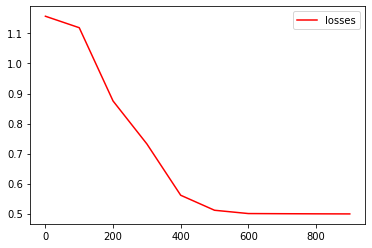

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(losses))*100,losses,color='red',label='losses')
#plt.plot(x,y2,color='green',label='cos(x)')

plt.legend()
plt.show()